In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import pycomlink as pycml
import pycomlink.processing.wet_dry.mlp as mlp

from poligrain.spatial import calc_sparse_intersect_weights_for_several_cmls
from poligrain.spatial import get_grid_time_series_at_intersections

import tqdm

In [2]:
# load data from your favourite sandbox path
ds_cml_all = xr.open_dataset('./data/openMRG_example.nc')
ds_rad = xr.open_dataset('./data/openMRG_example_rad.nc')

In [3]:
# calculate total loss
ds_cml_all["tl"] = ds_cml_all.tsl - ds_cml_all.rsl

In [4]:
# works best with one month of data, as this could potentially capture a rainfall event

# remove cmls with strong diurnal cycles 
ds_cml_all = ds_cml_all.where(
    ((ds_cml_all.tl.rolling(time = 60*5, center = True).std() > 2).sum(
        dim = 'time') / ds_cml_all.time.size <= 0.1).all(dim = 'sublink_id'),
    drop = True
)

# remove cmls with very noisy periods
ds_cml_all = ds_cml_all.where(
    (ds_cml_all.tl.rolling(time = 60, center = True).std() > 0.8).sum(
        dim = 'time') / ds_cml_all.time.size <= 0.35,
    drop = True
)

In [5]:
# Delay grids to allow dask to track them
intersect_weights = calc_sparse_intersect_weights_for_several_cmls(
    x1_line=ds_cml_all.site_0_lon.values,
    y1_line=ds_cml_all.site_0_lat.values,
    x2_line=ds_cml_all.site_1_lon.values,
    y2_line=ds_cml_all.site_1_lat.values,
    cml_id=ds_cml_all.cml_id.values,
    x_grid=ds_rad.lon.values,
    y_grid=ds_rad.lat.values, # 
)
    

In [6]:
start = ds_rad.time[0].values
end = ds_rad.time[-1].values

grid_data = ds_rad.sel(time=slice(start, end)).rainfall
R_rad = get_grid_time_series_at_intersections(
    grid_data = grid_data*(1/60), # to sum 1 min
    intersect_weights=intersect_weights,
).resample(time = '1min').bfill()

In [7]:
ds_cml_all['R_rad'] = (('time', 'cml_id'), np.zeros([ds_cml_all.time.size, ds_cml_all.cml_id.size]))
ds_cml_all['R_rad'].loc[{'time':R_rad.time}] = R_rad

In [8]:
# Threshold 15 minutes intervals larger than 0.01 mm 
ds_cml_all['wet'] = ds_cml_all.R_rad.resample(time = '15min').sum().resample(time = '1min').ffill() > 0.1/4

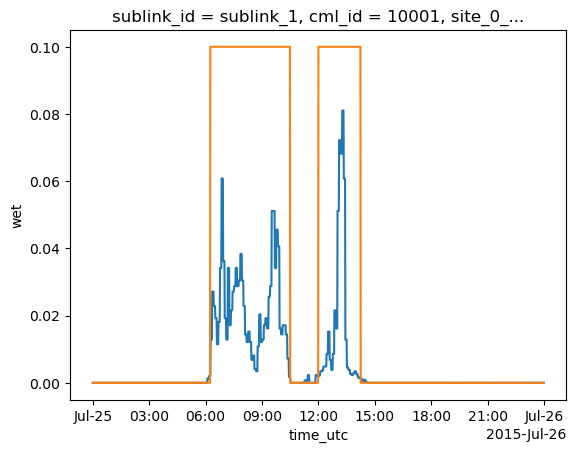

In [9]:
ds_cml_all.isel(cml_id = 0, sublink_id = 0).sel(
    time = slice('2015-07-25', '2015-07-25')).R_rad.plot()
(ds_cml_all.isel(cml_id = 0, sublink_id = 0).sel(
    time = slice('2015-07-25', '2015-07-25')).wet*0.1).plot()

In [10]:
# add 5 minutes to start of wet period 
# window_view = np.lib.stride_tricks.sliding_window_view(ds_cml_all.wet.data, window_shape=(6,1))
# extended_values = np.any(window_view, axis=(2, 3))
# padded_values = np.pad(extended_values, pad_width=((0, 5), (0, 0)), constant_values=False)
# ds_cml_all['wet_extended'] =(('time', 'cml_id'), padded_values)
# ds_cml_all.isel(cml_id = 0, sublink_id = 0).sel(time = slice('2015-07-25T05:50', '2015-07-25T12:05')).wet.plot()
# ds_cml_all.isel(cml_id = 0, sublink_id = 0).sel(time = slice('2015-07-25T05:50', '2015-07-25T12:05')).wet_extended.plot()




In [11]:
# wet when radar is wet
# radar_rain_thrs = 0.00167*4 # 0.001 correspods to 0.06 mm per hour # 00167 to 0.1, multiply by 4 to get 0.1 mm/15min
# ds_cml_all['wet'] = ds_cml_all['R_rad'] > radar_rain_thrs 

# # Set wet timesteps to nan
# ds_cml_all['tl_nan'] = xr.where(ds_cml_all.wet, np.nan, ds_cml_all.tl)

# # Use rolling median of dry timesteps as baseline
# ds_cml_all['baseline'] = xr.where(
#     ds_cml_all.wet, 
#     ds_cml_all.tl_nan.rolling(time = 60*5, min_periods = 60).median(), # 5 hours
#     ds_cml_all.tl
# )


ds_cml_all["baseline"] = pycml.processing.baseline.baseline_constant(
    trsl=ds_cml_all.tl,
    wet=ds_cml_all.wet,
    n_average_last_dry=5,
)

ds_cml_all = ds_cml_all.isel(sublink_id = 0)


In [12]:
# estimate the baseline during rain events


# # compenmsate for wet antenna attenuation
# cmls["waa"] = pycml.processing.wet_antenna.waa_schleiss_2013(
#     rsl=cmls.tl,
#     baseline=cmls.baseline,
#     wet=cmls.wet,
#     waa_max=2.2,
#     delta_t=1,
#     tau=15,
# )
# ds_cml_all["A_obs"] = ds_cml_all.tl - ds_cml_all.baseline
# ds_cml_all["A_obs"] = ds_cml_all.A_obs.where(ds_cml_all.A_obs >= 0, 0)

# ds_cml_all["waa"] = pycml.processing.wet_antenna.waa_leijnse_2008_from_A_obs(
#     A_obs=ds_cml_all.A_obs,
#     f_Hz=ds_cml_all.frequency * 1e6,
#     pol=ds_cml_all.polarization,
#     L_km=ds_cml_all.length / 1000,
# )
# # WAA from GRaf2020
#ds_cml_all["A_obs"] = ds_cml_all.tl - ds_cml_all.baseline
#ds_cml_all["A_obs"] = ds_cml_all.A_obs.where(ds_cml_all.A_obs >= 0, 0)
#ds_cml_all["waa"] = pycml.processing.wet_antenna.waa_leijnse_2008_from_A_obs(
#    A_obs=ds_cml_all.A_obs,
#    f_Hz=ds_cml_all.frequency*1e6,
#    pol=ds_cml_all.polarization,
#    L_km=ds_cml_all.length/ 1000, 
#    gamma = 1.47e-5, # Parameter that determines the magnitutde of the water film thickness (graf2020)
#    l_antenna = 0.0041, # antanna cover material tickness [meter] (graf2020)
#    delta = 0.36, # factor for the relation between the nonlinarity of rain rate and water film tickness
#)

ds_cml_all["A_obs"] = ds_cml_all.tl - ds_cml_all.baseline # can use different baselines
ds_cml_all["A_obs"] = ds_cml_all.A_obs.where(ds_cml_all.A_obs >= 0, 0)

# ds_cml_all["waa"] = pycml.processing.wet_antenna.waa_pastorek_2021_from_A_obs(
#     A_obs=ds_cml_all.A_obs,
#     f_Hz=ds_cml_all.frequency * 1e6,
#     pol=ds_cml_all.polarization.values,
#     L_km=ds_cml_all.length/ 1000,
#     A_max=9,
#     zeta=0.55, # 0.55 is default
# )
ds_cml_all["waa"] = pycml.processing.wet_antenna.waa_pastorek_2021_from_A_obs(
    A_obs=ds_cml_all.A_obs,
    f_Hz=ds_cml_all.frequency * 1e6,
    pol=ds_cml_all.polarization.data,
    L_km=ds_cml_all.length / 1000,
    A_max=6,
    zeta=0.7,  # 0.55 is default
    d=0.15,
)


# calculate attenuation caused by rain and remove negative attenuation
ds_cml_all["A"] = ds_cml_all.tl - ds_cml_all.baseline - ds_cml_all.waa
ds_cml_all["A"].values[ds_cml_all.A < 0] = 0
# derive rain rate via the k-R relation
ds_cml_all["R"] = pycml.processing.k_R_relation.calc_R_from_A(
    A=ds_cml_all.A,
    L_km=ds_cml_all.length.astype(float)/1000, # convert to km
    f_GHz=ds_cml_all.frequency/1000, # convert to GHz
    pol=ds_cml_all.polarization,
)/60 # to sum 1 min

In [13]:
# ds_cml_res = ds_cml_all.where(ds_cml_all.wet.mean(dim = 'time') > 0.05, drop = True).sel(
#     time = slice('2015-07-25T00:00', '2015-07-25T15:00')).isel(sublink_id = 0).R.resample(time = '5T').sum(skipna = True)/60

In [14]:
# slice data, resample to 5 min, convert to sum 5 min
ds_cml_res = ds_cml_all.sel(time = slice(ds_rad.time[0], ds_rad.time[-1])).resample(time = '5min').sum(skipna = True)

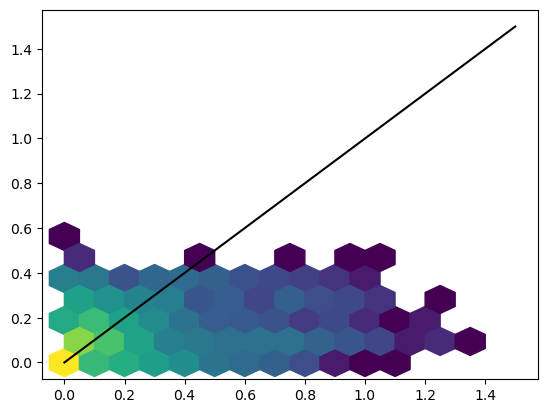

In [15]:
# Plot relations CML (xaxis) vs radar (yaxis) 
da_ra = []
da_cm = []
for i in range(100):
    da_cm.append(ds_cml_res.isel(cml_id = i).R.data)
    da_ra.append(ds_cml_res.isel(cml_id = i).R_rad.data)

da_cm = np.array(da_cm).ravel()
da_ra = np.array(da_ra).ravel()

# keep = da_ra > 0.1
# da_cm = da_cm[keep]
# da_ra = da_ra[keep]

plt.hexbin(
    da_cm,
    da_ra,
    mincnt=1,
    extent = [0, 1.5, 0, 1.5],
    gridsize = 15,
    bins='log'
)
plt.plot([0, 1.5], [0, 1.5], 'k')

(array([10.,  0.,  0.,  0.,  0.,  1.,  2.,  0.,  4.,  7.,  6., 11., 17.,
        18., 21., 22., 22., 31., 11., 21., 27., 25., 20., 21., 11., 10.,
        11.,  3.,  2.,  1.,  4.,  5.,  0.,  0.,  4.,  5.,  0.,  2.,  1.,
         1.]),
 array([ 0.        ,  0.50937201,  1.01874402,  1.52811603,  2.03748804,
         2.54686005,  3.05623206,  3.56560407,  4.07497609,  4.5843481 ,
         5.09372011,  5.60309212,  6.11246413,  6.62183614,  7.13120815,
         7.64058016,  8.14995217,  8.65932418,  9.16869619,  9.6780682 ,
        10.18744021, 10.69681222, 11.20618423, 11.71555625, 12.22492826,
        12.73430027, 13.24367228, 13.75304429, 14.2624163 , 14.77178831,
        15.28116032, 15.79053233, 16.29990434, 16.80927635, 17.31864836,
        17.82802037, 18.33739238, 18.84676439, 19.35613641, 19.86550842,
        20.37488043]),
 <BarContainer object of 40 artists>)

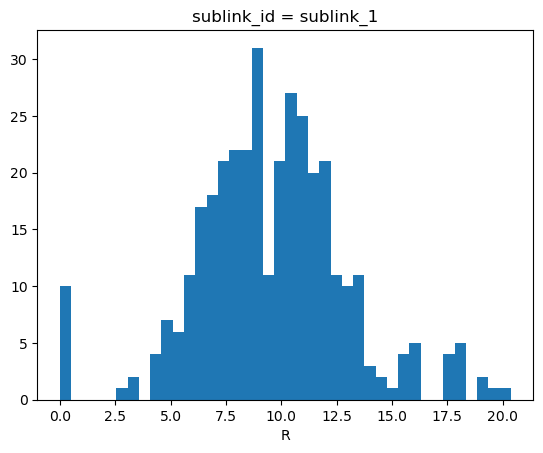

In [16]:
ds_cml_res.R.sum(dim = 'time').plot.hist(bins = 40)

In [17]:
# recognizing that 0 rainfall over the full period is a bit sucpicious we remove that group
keep = np.where(ds_cml_res.R.sum(dim = 'time') > 0)[0]
ds_cml_res = ds_cml_res.isel(cml_id = keep)

(array([ 2.,  1.,  0.,  5.,  6.,  6.,  8., 13., 17., 14., 24., 14., 19.,
        27., 16.,  7., 25., 19., 24., 16., 20., 13.,  8.,  7.,  8.,  3.,
         1.,  2.,  3.,  2.,  4.,  0.,  0.,  4.,  4.,  1.,  1.,  1.,  1.,
         1.]),
 array([ 2.9507253 ,  3.38632918,  3.82193306,  4.25753694,  4.69314082,
         5.12874469,  5.56434857,  5.99995245,  6.43555633,  6.87116021,
         7.30676408,  7.74236796,  8.17797184,  8.61357572,  9.0491796 ,
         9.48478348,  9.92038735, 10.35599123, 10.79159511, 11.22719899,
        11.66280287, 12.09840674, 12.53401062, 12.9696145 , 13.40521838,
        13.84082226, 14.27642613, 14.71203001, 15.14763389, 15.58323777,
        16.01884165, 16.45444552, 16.8900494 , 17.32565328, 17.76125716,
        18.19686104, 18.63246491, 19.06806879, 19.50367267, 19.93927655,
        20.37488043]),
 <BarContainer object of 40 artists>)

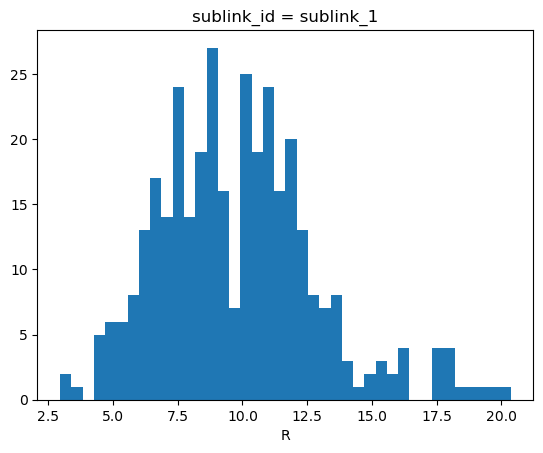

In [18]:
ds_cml_res.R.sum(dim = 'time').plot.hist(bins = 40)

(array([ 9., 28., 46., 62., 56., 41., 22.,  7.,  7.,  7.,  9.,  6.,  3.,
         1.,  2.,  3.,  3.,  3.,  4.,  2.,  3.,  2.,  1.,  6.,  1.,  0.,
         1.,  2.,  2.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,
         4.]),
 array([ 6.52451206,  6.83940006,  7.15428807,  7.46917607,  7.78406407,
         8.09895207,  8.41384007,  8.72872808,  9.04361608,  9.35850408,
         9.67339208,  9.98828008, 10.30316809, 10.61805609, 10.93294409,
        11.24783209, 11.56272009, 11.8776081 , 12.1924961 , 12.5073841 ,
        12.8222721 , 13.1371601 , 13.45204811, 13.76693611, 14.08182411,
        14.39671211, 14.71160011, 15.02648812, 15.34137612, 15.65626412,
        15.97115212, 16.28604012, 16.60092813, 16.91581613, 17.23070413,
        17.54559213, 17.86048013, 18.17536814, 18.49025614, 18.80514414,
        19.12003214]),
 <BarContainer object of 40 artists>)

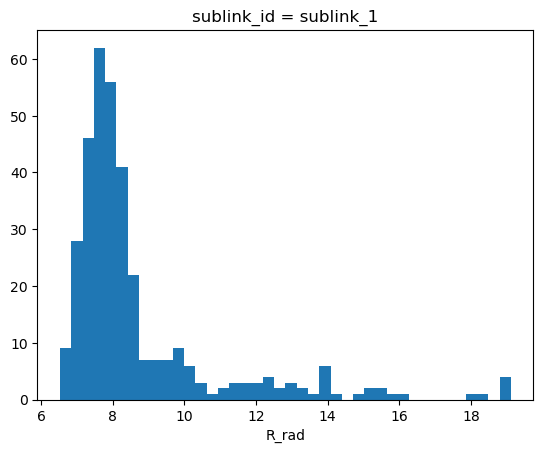

In [19]:
ds_cml_res.R_rad.sum(dim = 'time').plot.hist(bins = 40)

In [20]:
# store in project folder
ds_cml_res.to_netcdf('./data/ds_cml_ompenmrg.nc')